In [1]:
### dimension reduce & cluster with UMAP

import umap
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from io import BytesIO
from PIL import Image
import base64

from bokeh.plotting import figure, show, output_notebook, save
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.transform import factor_mark

2024-05-13 16:22:13.088794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-13 16:22:13.088843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-13 16:22:13.089955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-13 16:22:13.095882: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 16:22:13.824251: W tensorflow/compiler/tf2

In [2]:
## import features and charter listf

array_path = r"/home/tschernn/becore-clustering/img_array.pkl"

with open(array_path, 'rb') as file:
    img_array = pickle.load(file)

feature_path = r"/home/tschernn/becore-clustering/features_hog.pkl"

with open(feature_path, 'rb') as file:
    data = pickle.load(file)

charter_path = r"/home/tschernn/becore-clustering/charter_list.pkl"

with open(charter_path, 'rb') as file:
    charters = pickle.load(file)

data.shape

(267, 267)

In [3]:
img_vectors = [img.flatten() for img in img_array]
img_vectors = np.array(img_vectors)
img_vectors.shape

(267, 2359296)

In [4]:
## fit and transform

reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

# UMAP by default reduces to 2D
embedding.shape

(267, 2)

In [5]:
reducer = umap.UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)
reducer.fit(data.data)

embedding = reducer.transform(data.data)

/home/tschernn/.local/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


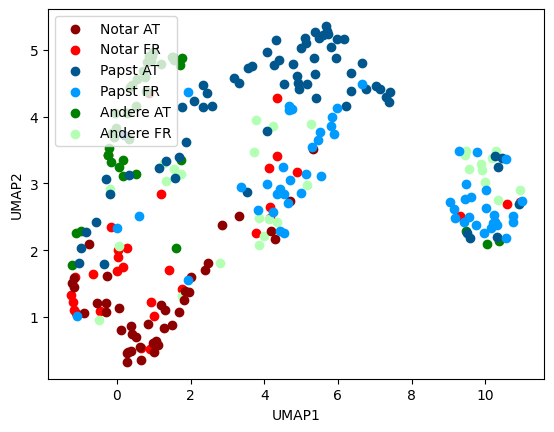

In [6]:
## plot data

label_color_map = {
    'writable_area_notar_oe': '#8e0000', # dark red
    'writable_area_notar_fr': '#ff0000', # light red
    'writable_area_papst_oe': '#00578e', # dark blue
    'writable_area_papst_fr': '#009bff', # light blue
    'writable_area_sonstige_oe': '#008000', # dark green
    'writable_area_sonstige_fr': '#b3ffb3', # light green
}

legend_labels = {
    'writable_area_notar_oe': 'Notar AT', # dark red
    'writable_area_notar_fr': 'Notar FR', # light red
    'writable_area_papst_oe': 'Papst AT', # dark blue
    'writable_area_papst_fr': 'Papst FR', # light blue
    'writable_area_sonstige_oe': 'Andere AT', # dark green
    'writable_area_sonstige_fr': 'Andere FR' # light green
}

# create dummy scatter plots for legend
legend_handles = []
for label, color in label_color_map.items():
    legend_handles.append(plt.scatter([], [], c=color, label=legend_labels[label]))

for point, charter in zip(embedding, charters):
    x, y = point
    label = charter[1]
    color = label_color_map[label]
    plt.scatter(x, y, c=color)

# Create a legend
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(handles=legend_handles, loc='upper left')

plt.savefig('umap_plot.jpg')

In [7]:
### export data as pickle file
feature_path = feature_path.split('.')[0]
feature_path = feature_path + '_dimred.pkl'

with open(feature_path,'wb') as file:
    pickle.dump(embedding, file)
    print(f'Saved features as {file.name}.')

Saved features as /home/tschernn/becore-clustering/features_hog_dimred.pkl.


In [8]:
### remove unneeded img_array dimensions

img_array = img_array[:, :, :, 0]
img_array.shape

(267, 1024, 768)

In [44]:
### bokeh implementation adapted from https://umap-learn.readthedocs.io/en/latest/basic_usage.html

def embeddable_image(data):
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((256, 256), Image.Resampling.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()


## draw plot

output_notebook()

charters_df = pd.DataFrame(embedding, columns=('x', 'y'))

charters_df['class'] = [x[1].split('_')[-2] for x in charters]
charters_df['origin'] = [x[1].split('_')[-1] for x in charters]
charters_df['image'] = list(map(embeddable_image, img_array))
charters_df['name'] = [x[0] for x in charters]

plot_figure = figure(
    title = 'UMAP projection of the charters',
    width = 1000,
    height = 1000,
    tools = ('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>Charter:</span>
        <span style='font-size: 18px'>@name</span>
    </div>
</div>
"""))

legend_entries = []

for class_name, color in zip(charters_df['class'].unique(), ['#8e0000', '#008000', '#00578e']):
    for origin_name, marker in zip(charters_df['origin'].unique(), ['asterisk', 'circle']):
        class_data = charters_df[charters_df['class'] == class_name]
        class_data = class_data[charters_df['origin'] == origin_name]
        plot_figure.scatter(
            'x',
            'y',
            source = class_data,
            color = color,
            marker = marker,
            line_alpha = 0.6,
            fill_alpha = 0.6,
            size = 7,
            legend_label = f'{class_name.title()} {origin_name.upper()}'
        )
        # Append legend entry
        legend_entries.append((f'{class_name.title()} {origin_name.upper()}', [plot_figure.renderers[-1]]))

save(plot_figure, filename='umap_plot.html')
#show(plot_figure)

Loading BokehJS ...

/tmp/ipykernel_2854193/1889901878.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_data = class_data[charters_df['origin'] == origin_name]
/tmp/ipykernel_2854193/1889901878.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_data = class_data[charters_df['origin'] == origin_name]
/tmp/ipykernel_2854193/1889901878.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_data = class_data[charters_df['origin'] == origin_name]
/tmp/ipykernel_2854193/1889901878.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_data = class_data[charters_df['origin'] == origin_name]
/tmp/ipykernel_2854193/1889901878.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  class_data = class_data[charters_df['origin'] == origin_name]
/tmp/ipykernel_2854193/1889901878.py:47: UserWarning: Boolean Series key will be reindexed to m

'/home/tschernn/becore-clustering/umap_plot.html'

In [43]:
charters_df['origin'].unique()

array(['fr', 'oe'], dtype=object)

In [31]:
origin_data

,x,y,class,origin,image,name
60,-0.246077,3.424357,notar,oe,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",wa_8544fbf2dd85548814be30f60f9e012c.jpg
61,1.845421,1.390726,notar,oe,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",wa_77d63365260e4f4f6b999bfb2dc7db88.jpg
62,0.372560,0.859005,notar,oe,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",wa_818a647bfd4bf7024f0af5578ea201a1.jpg
63,0.276006,0.457543,notar,oe,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",wa_f005f93c068987ca8e2e19783e6f9db5.jpg
64,-0.524759,1.204572,notar,oe,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",wa_4d815e1c2fc031ecea00f73168743bc9.jpg
...,...,...,...,...,...,...
207,5.692113,5.283390,papst,oe,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",wa_5350aaa8b0869c948206aa9d7fd30cc6.jpg
208,-0.307048,3.067331,papst,oe,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",wa_9dc94150b98113ef5c70d4e8e5a66260.jpg
209,6.761218,4.409548,papst,oe,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",wa_30111c186b060268789e4a4ec66d962a.jpg
210,0.184382,3.726527,papst,oe,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",wa_029c6f82bfe6be96aa515a05a05b8528.jpg
